In [1]:
import jax.numpy as jnp
import jax
jax.config.update("jax_enable_x64", True)

import numpy as np
import scipy
import matplotlib.pyplot as plt

import sys, os

In [2]:
sys.path.insert(0, "/home/storage/hans/jax_reco_new")
from lib.cgamma import c_gamma_prob
from lib.plotting import adjust_plot_1d
from lib.network import get_network_eval_fn
from lib.geo import get_xyz_from_zenith_azimuth
from lib.trafos import transform_network_outputs, transform_network_inputs

In [3]:
eval_network = get_network_eval_fn(bpath='/home/storage/hans/jax_reco_new/data/network')

In [116]:
dist = 5
z = -210
rho = 0.0
zenith = np.pi/2
azimuth = 0.0

x = jnp.array([dist, rho, z, zenith, azimuth])
x_prime = transform_network_inputs(x)
y = eval_network(x_prime)
logits, gamma_as, gamma_bs = transform_network_outputs(y)
mix_probs = jax.nn.softmax(logits)

# index 1 is main component
gamma_a = gamma_as[1]
gamma_b = gamma_bs[1]
sigma = 3

print(gamma_a, gamma_b)

3.7463812163854007 1.9994916781637078


In [117]:
print(mix_probs.shape)

(3,)


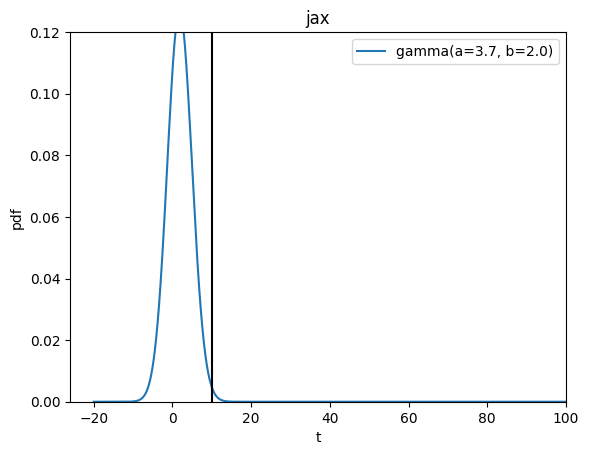

In [130]:
xmax = 100
xvals = jnp.linspace(-20, xmax, 10000)
yvals = c_gamma_prob(xvals, gamma_a, gamma_b, sigma=sigma)


fig, ax = plt.subplots()
ax.plot(xvals, yvals, label=f'gamma(a={gamma_a:.1f}, b={gamma_b:.1f})')
ax.axvline(10, color='black')
ax.set_xlabel('t')
ax.set_ylabel('pdf')
ax.legend()
ax.set_title('jax')
ax.set_xlim(xmax=xmax)
ax.set_ylim([0.0, 0.12])
plt.show()

In [119]:
from jax.scipy.integrate import trapezoid
#x_int = jnp.linspace(-20, (gamma_a-1)/gamma_b, 10000)
x_int = jnp.linspace(-20, 10, 10000)
y_int = c_gamma_prob(x_int, gamma_a, gamma_b, sigma=sigma)
print(trapezoid(y_int, x=x_int))
print(1-trapezoid(y_int, x=x_int))

0.9945489504192409
0.005451049580759149


In [120]:
from jax.scipy.special import gammaincc, erf

In [121]:
def c_gamma_sf(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    alpha = 2.5 # controls the split of the integral => precision.
    n_steps = 10 # controls the support points in trapezoidal integration

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
    
    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0) 
    
    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    x_int = jnp.linspace(ymin, ymax, n_steps, axis=-1)

    # add dimension to end for proper broadcasting during integration
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    term2 *= trapezoid(y_int, x=x_int, axis=-1)

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=0.0, max=1.0)  

In [138]:
@jax.jit
def c_multi_gamma_sf(x, mix_probs, a, b, sigma=3.0):
    probs = c_gamma_sf(x, a, b, sigma=sigma)
    return jnp.sum(mix_probs * probs, axis=-1)

c_multi_gamma_sf_v = jax.jit(jax.vmap(c_multi_gamma_sf, (0, 0, 0, 0), 0))

In [139]:
def c_gamma_sf_precise(x, a, b, sigma=3.0, delta=0.1):
    x_int = jnp.linspace(-20, x, 10000)
    y_int = c_gamma_prob(x_int, a, b, sigma=sigma, delta=0.1)
    return 1.0-trapezoid(y_int, x=x_int)

In [161]:
def c_gamma_sf_by_hand(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    alpha = 2.5 # controls the split of the integral => precision.
    n_steps = 20 # controls the support points in trapezoidal integration

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
    
    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0) 
    
    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    x_int = jnp.linspace(ymin, ymax, n_steps+1, axis=-1)
    x_int = 0.5 * (x_int[..., 1:] + x_int[..., :-1])
    dx = jnp.expand_dims(x_int[..., 1] - x_int[..., 0], axis=-1)

    # add dimension to end for proper broadcasting during integration
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    term2 *= jnp.sum(y_int * dx, axis=-1)

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=0.0, max=1.0)  

In [169]:
def c_gamma_sf_by_hand2(x, a, b, sigma=3.0):
    """
    following arXiv:astro-ph/0506136
    """
    alpha = 2.5 # controls the split of the integral => precision.
    n_steps = 10 # controls the support points in trapezoidal integration

    sqrt2sigma2 = jnp.sqrt(2.0*sigma**2)
    
    ymin = x - alpha*sqrt2sigma2 # start of numeric integration
    ymin = jnp.where(ymin >= 0.0, ymin, 0.0) 
    
    ymax = x + alpha*sqrt2sigma2 # end of numeric integration
    ymax = jnp.where(ymax >= 0.0, ymax, 0.0)
    # todo: think about special case when ymin = ymax = 0.0
    # based on testing so far: no need to do anything.

    term1 = gammaincc(a, b*ymax) + gammaincc(a, b*ymin)
    term2 = jnp.power(b, a) # J in arXiv:astro-ph/0506136

    x_int = jnp.linspace(ymin, ymax, n_steps, axis=-1)
    dx = x_int[..., 1] - x_int[..., 0]
    xm0 = 0.5*(x_int[..., 0] + x_int[..., 1])

    x_int = x_int[..., 1:]
    # add dimension to end for proper broadcasting during integration
    a_e = jnp.expand_dims(a, axis=-1)
    b_e = jnp.expand_dims(b, axis=-1)
    y_int = jnp.power(x_int, a_e-1) * jnp.exp(-b_e*x_int) * erf((x-x_int)/sqrt2sigma2)
    term2 *= (jnp.squeeze(dx * jnp.power(xm0, a_e-1) * jnp.exp(-b_e*xm0) * erf((x-xm0)/sqrt2sigma2)) \
              + trapezoid(y_int, x=x_int, axis=-1))

    sf = 0.5 * (term1 - term2/jax.scipy.special.gamma(a))
    return jnp.clip(sf, min=0.0, max=1.0)  

In [171]:
t = jnp.array(17.0)
cheap = c_gamma_sf_by_hand(t, gamma_a, gamma_b)
expensive = c_gamma_sf_precise(t, gamma_a, gamma_b)
print(cheap, expensive, (cheap-expensive)/expensive)

0.00016912899501789295 2.8548370478720386e-07 591.4295929393227


In [246]:
n_repeats = 100
ts = jnp.repeat(t, n_repeats, axis=0)
gamma_ass = gamma_as.reshape((1,3))
gamma_ass = jnp.repeat(gamma_ass, n_repeats, axis=0)
gamma_bss = gamma_bs.reshape((1,3))
gamma_bss = jnp.repeat(gamma_bss, n_repeats, axis=0)
mix_probss = mix_probs.reshape((1,3))
mix_probss = jnp.repeat(mix_probss, n_repeats, axis=0)

#probs = c_gamma_sf(t, gamma_ass, gamma_bss)
#print(probs.shape)
probs_fast = c_gamma_sf(t, gamma_as, gamma_bs)
print(probs_fast)

[0.89326938 0.42979151 0.98423091]


In [247]:
print(mix_probs)
print(c_multi_gamma_sf(t, mix_probs, gamma_as, gamma_bs))

[0.29058582 0.58944076 0.11997342]
0.6309895971325675


In [248]:
print(ts.shape)
print(gamma_ass.shape)
print(gamma_bss.shape)
print(mix_probss.shape)
y = c_multi_gamma_sf_v(ts, mix_probss, gamma_ass, gamma_bss)
print(y.shape)

(100,)
(100, 3)
(100, 3)
(100, 3)
(100,)


In [250]:
print(y)

[0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896 0.6309896
 0.630

In [249]:
%timeit c_multi_gamma_sf_v(ts, mix_probss, gamma_ass, gamma_bss).block_until_ready()

622 μs ± 689 ns per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [219]:
%timeit c_multi_gamma_sf(t, mix_probs, gamma_as, gamma_bs).block_until_ready()

431 μs ± 5.71 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [189]:
probs = []
for i in range(3):
    a = gamma_as[i]
    b = gamma_bs[i]
    probs.append(c_gamma_sf_precise(t, a, b))

print(probs)
print((jnp.array(probs)-probs_fast)/probs_fast)

[Array(0.88937922, dtype=float64), Array(0.43040139, dtype=float64), Array(0.98326558, dtype=float64)]
[-0.00435496  0.001419   -0.00098079]


In [138]:
x = jnp.linspace(jnp.array([10, 20]).reshape((2, 1)), jnp.array([30, 40]).reshape((2, 1)), 20, axis=-1)

In [139]:
print(x.shape)

(2, 1, 20)


In [200]:
x_int = jnp.linspace(0.0, 0.0, 100)
y_int = jnp.power(x_int, 2.0)
print(trapezoid(y_int, x=x_int))

0.0


In [33]:
2.5*np.sqrt(2)

3.5355339059327378

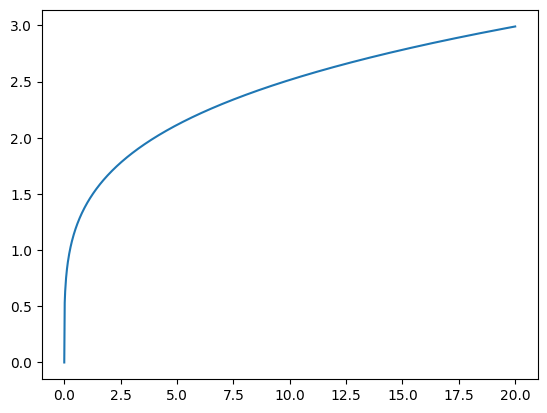

In [37]:
delta = 4.0
xvals = np.linspace(0.0, 20.0, 1000)
yvals = (xvals * delta) ** (1/delta)

plt.plot(xvals, yvals)
plt.show()